## TODO
1. Add surface temp and skin temp to rtmodel call
2. Add transect filepath to transect summary - filter on just transects
3. Plot time series of fluxes
4. Compare estimated downwelling SW and observed SW

In [1]:
import sys
sys.path.append("../mosaic_underice_sunlight/")

import warnings  # to ignore future warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from rtmodel import seaicert_mp
from plotting import plot_results, plot_thickness_profile
from mosaic_thickness import load_cleaned_transect, load_transect_metadata
from filepath import FORCING_DATAPATH, RESULTS_DATAPATH

from data.get_metdata_for_transects import load_transect_summary

/home/apbarret/mambaforge/envs/mosaic_underice_sunlight/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_results_path(fp, model, output_type="data"):
    fp_out = RESULTS_DATAPATH / fp.relative_to(fp.parents[2])
    if output_type == "data":
        return fp_out.parent / (fp_out.stem + f".{model}.csv")
    elif output_type == "figure":
        return fp_out.parent / (fp_out.stem + f".{model}.png")
    else:
        raise KeyError("Unexpected output_type {output_type}.\nExpects one of data, figure")

In [3]:
transects = FORCING_DATAPATH.glob("**/*.csv")
load_cleaned_transect(next(transects))

,lon,lat,local_x,local_y,ice_thickness_m,snow_depth_m,melt_pond_depth_m,surface_type,transect_distance_m,ice_thickness_flag,measured_irradiance_wm2,air_temperature_K,surface_temperature_K
date/time,,,,,,,,,,,,,
2020-07-26 12:07:31,-1.76059,79.79109,-144.658073,-75.028463,4.454297,0.03596,0.0,1,0.000000,1,443.000162,274.373126,273.15
2020-07-26 12:07:36,-1.76060,79.79105,-147.019467,-72.106408,4.629537,0.03932,0.0,1,3.756938,1,443.000162,274.373126,273.15
2020-07-26 12:07:42,-1.76059,79.79102,-147.068853,-69.307964,4.173537,0.04212,0.0,1,6.555818,1,443.000162,274.373126,273.15
2020-07-26 12:07:47,-1.76055,79.79099,-148.182672,-67.716197,4.178577,0.03708,0.0,1,8.498577,1,443.000162,274.373126,273.15
2020-07-26 12:07:53,-1.76047,79.79096,-149.527806,-65.661261,3.298234,0.04548,0.0,1,10.954621,1,443.000162,274.373126,273.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-26 14:54:15,-1.91655,79.76538,480.583782,-115.690890,2.961846,0.03204,0.0,1,3153.704487,1,443.000162,274.373126,273.15
2020-07-26 14:54:19,-1.91651,79.76536,478.971267,-112.759539,2.375137,0.03372,0.0,1,3157.050084,1,443.000162,274.373126,273.15
2020-07-26 14:54:22,-1.91641,79.76533,477.695341,-111.047834,2.091926,0.04716,0.0,1,3159.185013,1,443.000162,274.373126,273.15


In [3]:
%%time

plt.ioff()

for transect in FORCING_DATAPATH.glob("**/*.csv"):

    print(f"Running model for {transect.name}")
    
    # Make output paths
    data_path = make_results_path(transect, "seaicert", output_type="data")
    figure_path = make_results_path(transect, "seaicert", output_type="figure")

    # Create paths if they do not exist
    figure_path.parent.mkdir(parents=True, exist_ok=True)
    data_path.parent.mkdir(parents=True, exist_ok=True)

    # Load data
    df = load_cleaned_transect(transect)

    # Run model
    try:
        rt_df = seaicert_mp(df)
    except ValueError as err:
        print(err)
        print("Skipping!")
        continue

    # Save results
    rt_df.to_csv(data_path)

    # Make plot and save
    fig = plot_results(rt_df, title=transect.name)
    fig.savefig(figure_path)

    plt.close()

Running model for magnaprobe_and_gem2_transect_20200726_PS122-4_48-250_transect.csv
Ice thickness must be positive
Skipping!
Running model for magnaprobe_and_gem2_transect_20200727_PS122-4_49-115_albedoRBB.csv
Running model for magnaprobe_and_gem2_transect_20200727_PS122-4_49-115_transect.csv
Ice thickness must be positive
Skipping!
Running model for magnaprobe_and_gem2_transect_20200727_PS122-4_49-116_albedoLD.csv
Ice thickness must be positive
Skipping!
Running model for magnaprobe_and_gem2_transect_20200728_PS122-4_49-120_ridge.csv
Running model for magnaprobe_and_gem2_transect_20200827_PS122-5_59-411_special.csv
Ice thickness must be positive
Skipping!
Running model for magnaprobe_and_gem2_transect_20200828_PS122-5_59-412_ridge.csv
Running model for magnaprobe_and_gem2_transect_20200830_PS122-5_59-413_albedoK.csv
Ice thickness must be positive
Skipping!
Running model for magnaprobe_and_gem2_transect_20200830_PS122-5_59-413_ARIEL.csv
Running model for magnaprobe_and_gem2_transect_20

## Generate summary results for each transect

In [22]:
summary = []
index = []
for result in RESULTS_DATAPATH.glob("**/*.csv"):
    df = pd.read_csv(result, parse_dates=True, index_col=0)

    df_summ = df.aggregate({
        "lon": "mean",
        "lat": "mean",
        "local_x": "mean",
        "local_y": "mean",
        "ice_thickness_m": "mean",
        "snow_depth_m": "mean",
        "transect_distance_m": "max",
        "melt_pond_depth_m": "mean",
        "measured_irradiance_wm2": "mean",
        "air_temperature_K": "mean",
        "surface_temperature_K": "mean",
        "sw_absorbed_by_ocean": "mean",
        "lw_absorbed_by_ocean": "mean",
        "downwelling_radiative_flux_absorbed_by_ocean": "mean",
        "qpar_absorbed_by_ocean": "mean",
        "surface_albedo": "mean",
        "surface_downwelling_radiative_flux": "mean",
    })
    df_summ["melt_pond_fraction"] = (df.melt_pond_depth_m > 0).sum() / df.melt_pond_depth_m.count()
    summary.append(df_summ.to_dict())
    index.append(df.index[0])
summary_df = pd.DataFrame(summary, index=index)
             

In [23]:
summary_df

,lon,lat,local_x,local_y,ice_thickness_m,snow_depth_m,transect_distance_m,melt_pond_depth_m,measured_irradiance_wm2,air_temperature_K,surface_temperature_K,sw_absorbed_by_ocean,lw_absorbed_by_ocean,downwelling_radiative_flux_absorbed_by_ocean,qpar_absorbed_by_ocean,surface_albedo,surface_downwelling_radiative_flux,melt_pond_fraction
2020-07-27 14:57:20,-2.460096,79.555600,329.978327,-664.678512,2.712284,0.051686,219.945288,0.017883,400.303337,274.587568,273.150000,1.902627,0.00000,1.902627,6.673653,0.764940,262.752762,0.160000
2020-07-28 12:08:02,-2.687949,79.364297,-390.183101,-604.512070,4.729241,0.076857,48.376182,0.000000,157.678314,274.657484,273.150000,0.040244,0.00000,0.040244,0.141159,0.849429,330.649385,0.000000
2020-08-28 08:27:12,108.906862,88.033719,92.855407,-63.938322,5.376807,0.078345,332.684254,0.000000,58.254328,273.500161,273.150000,0.027253,0.00000,0.027253,0.095593,0.852074,87.532081,0.000000
2020-08-30 09:45:24,112.105570,88.223552,-44.867409,-209.104268,1.442887,0.049594,120.897831,0.000000,39.310562,272.693646,273.150000,0.722094,0.00000,0.722094,2.532817,0.837876,78.651543,0.000000
2020-09-02 08:34:59,117.608015,88.430017,-40.496127,-652.345999,1.878403,0.020549,2159.174463,0.048013,60.048348,272.206113,272.056035,1.811737,0.00004,1.811778,6.354992,0.700910,57.909087,0.160164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 12:01:34,8.945234,81.791924,-109.239512,-489.253031,2.322019,0.095063,3307.989085,0.012540,463.896354,273.259082,272.764556,2.987601,0.00000,2.987601,10.479308,0.814365,338.853493,0.074210
2020-07-02 11:29:30,8.423442,81.721868,-86.934115,-505.313643,2.435614,0.099730,3289.856771,0.014060,135.654055,272.536000,272.946098,2.522324,0.00000,2.522324,8.847305,0.814166,349.616212,0.077196
2020-07-03 07:22:03,7.740978,81.681712,-45.660384,-515.955859,2.388211,0.083996,3296.078265,0.014321,134.406727,273.646119,272.450883,2.347453,0.00000,2.347453,8.233925,0.808203,296.298980,0.078923
2020-04-24 13:02:56,15.880790,84.045366,614.396782,-15.174235,0.460182,0.475234,39.559871,0.000000,303.733203,257.407859,257.072953,0.176462,0.00000,0.176462,0.618959,0.872410,196.341527,0.000000


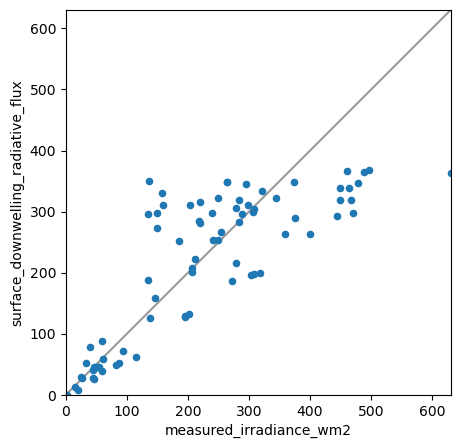

In [35]:
xmin = min(summary_df.measured_irradiance_wm2.min(), 
           summary_df.surface_downwelling_radiative_flux.min())
xmax = max(summary_df.measured_irradiance_wm2.max(), 
           summary_df.surface_downwelling_radiative_flux.max())

fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect("equal")
summary_df.plot.scatter(x="measured_irradiance_wm2", y="surface_downwelling_radiative_flux",
                        ax=ax, xlim=(xmin,xmax), ylim=(xmin,xmax))
ax.axline((1,1), slope=1, color="0.6", zorder=0)

In [36]:
summary_df.columns

Index(['lon', 'lat', 'local_x', 'local_y', 'ice_thickness_m', 'snow_depth_m',
       'transect_distance_m', 'melt_pond_depth_m', 'measured_irradiance_wm2',
       'air_temperature_K', 'surface_temperature_K', 'sw_absorbed_by_ocean',
       'lw_absorbed_by_ocean', 'downwelling_radiative_flux_absorbed_by_ocean',
       'qpar_absorbed_by_ocean', 'surface_albedo',
       'surface_downwelling_radiative_flux', 'melt_pond_fraction'],
      dtype='object')

In [41]:
summary_df.sort_index(inplace=True)

<Axes: >

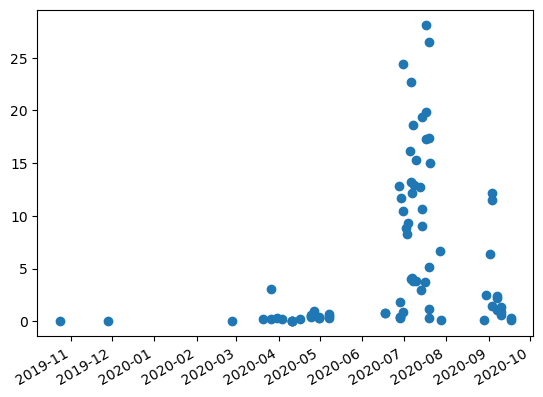

In [44]:
summary_df.qpar_absorbed_by_ocean.plot(ls='', marker='o')